In [1]:
from collections import defaultdict

import numpy as np
import torch as th

import matplotlib as mpl
import matplotlib.pyplot as plt

from mdps import MDP, Env
from mdps.algorithms import policy_evaluation, policy_improvement, policy_iteration
from mdps.blueprints import FOUR_ROOMS, TWO_ROOMS
from mdps.plot_utils import plot_policy, view_cmap

In [2]:
np.set_printoptions(precision=3, linewidth=128, suppress=True)
# plt.rcParams['figure.figsize'] = [5.0, 5.0]
# plt.rcParams['figure.dpi'] = 70

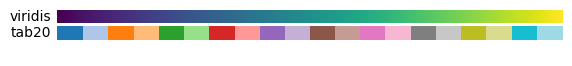

In [3]:
view_cmap('viridis', 'tab20')

# Markov decision processes. Q-iteration and Policy-iteration.

- regulament
- introduction

## Description

There are two main objects in this "library":

- an `MDP` which follows the Markov Decision Process formalism and encapsulates objects such as the set of states $S$, the transition dynamics $P$, and the reward function.
- an `Env`, which takes an `MDP` as argument and makes out of it an _environment_ exposing methods that make possible the agent-environment interaction loop (more on this later).

First, let's focus on the `MDP` class. It allows for easy definition of MDPs from a very simple domain specific language we call a `Blueprint`. Here's an example.

Remember the cleaning robot from our lectures:

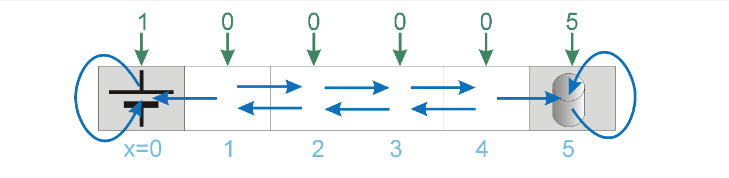

We can define this MDP using a few conventions:
- ` ` (space) is a special token, it indicates a state in which you can move in.
- `x` is a special token, it indicates an wall.
- `s` is a special token, it indicates the starting state.
- uppercase letters such as `T` (trash), `B` (battery) or `G` (goal) are terminal or absorbing states which end the episode.
- lowercase letters other that the special tokens above indicate rewarding states.
- everything above `---` is used to define rewards as field-value pairs:
    - `x: -0.1` negative reward when bumping into walls. 
    - `.: 0.0` reward associated with moving. Usually negative.
    - `T: 5.0` reward of 5 for picking up the trash (and restarting the episode)
    - `B: 1.0` rweard of 1 for charging the battery (and restarting the episode)

Here's how you define the Cleaning Robot MDP using this DSL:

In [4]:
ROOMBA = """
B: 1.0
T: 5.0
x: -1.0
.: 0.0
---
xxxxxxxx
xB  s Tx
xxxxxxxx
"""

In [5]:
MDP(ROOMBA)

xxxxxxxx
xB  s Tx
xxxxxxxx
Actions: 0: up, 1: right, 2: down, 3: left

### MDP interface

- `mpd.S` return the list of states reachable $S$

**For solving Q-iteration you are only required to know about:**
- `mdp.f(x: int, u: int) -> x': int` returns the next state `x'` when applying action `u` while in state `x`.
- `mdp.rho(x: int, u: int) -> r: float` returns the reward `r` when applying action `u` while in state `x`.
- `mdp.ρ(x: int, u: int) -> r: float` is a shorthand (alias) of `mdp.rho`


### WIP section
**In addition:**
- `mdp.Psas` return a tensor $P$ such that for state `s`, action `a` and next state `s'`, $P_{s,a,s'} = p(s' | s, a)$. This is the **transition** function of the environment.
- `mdp.Rsas` return a tensor $R$ such that for state `s`, action `a` and next state `s'`, $R_{s,a,s'} = r(s, a, s')$. This is the **reward** function of the environment.

In [6]:
mdp = MDP(ROOMBA)
mdp

xxxxxxxx
xB  s Tx
xxxxxxxx
Actions: 0: up, 1: right, 2: down, 3: left

In [7]:
# get the action-state dimensionality
print(f"#states:  {mdp.num_states}")
print(f"#actions: {mdp.num_actions}")
print(f"states:   {mdp.S}")

#states:  6
#actions: 4
states:   [0, 1, 2, 3, 4, 5]


In [8]:
for x, u in ((4, 1), (1, 3), (3, 0)):
    print(f"Cleaner is in state x={x} and it applies action u={u}. Arrives in next state x={mdp.f(x, u)} with reward r={mdp.rho(x, u)}")

Cleaner is in state x=4 and it applies action u=1. Arrives in next state x=5 with reward r=5.0
Cleaner is in state x=1 and it applies action u=3. Arrives in next state x=0 with reward r=1.0
Cleaner is in state x=3 and it applies action u=0. Arrives in next state x=3 with reward r=-1.0


In [10]:
print(mdp.Psas.shape)
print("p(s'=5 | s=4, a=1): ", mdp.Psas[4,1,5])
print("p(s'= · | s=4, a=·): \n", mdp.Psas[4,:, :])

(6, 4, 6)
p(s'=5 | s=4, a=1):  1.0
p(s'= · | s=4, a=·): 
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [185]:
print("rho(s'= · | s=17, a=·): \n", mdp.Rsas[7,:, :])

p(s'= · | s=17, a=·): 
 [[ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]


##  Q-iteration (value iteration with Q-values)

In [9]:
# TODO move in MDP
def plot_qsa(Q):
    fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
    for qa, u in zip(Q.t(), ('top', 'right', 'down', 'left')):
        ax.plot(qa, label=f'Q(x, {u})')
    ax.legend()

### Task 1

Implement Q-iteration.
The signature of the function is given below.
It receives:

- the `MDP` object
- the value of `γ`
- and a default value of `1e-4` for `ε_iter`

**Important:** test your implementation using the `ROOMBA` mdp.
The results should match closely the observations presented during the lecture.

In [10]:
def q_iteration(mdp, γ, ε_iter=1e-4):
    # TODO: your implementation here
    Qs = [th.zeros((mdp.num_states, mdp.num_actions))]
    while True:
        Q = Qs[len(Qs) - 1].clone()
        for x in mdp.S:
            for u in range(mdp.num_actions):
                Q[x, u] = mdp.ρ(x, u) + γ * Q[mdp.f(x, u)].max()
        Qs.append(Q)
        if (Qs[-2] - Q).abs().max() <= ε_iter:
            break
    print(f"Finished in {len(Qs)} iterations.")
    return Qs[-1]

In [11]:
mdp = MDP(ROOMBA)
Q = q_iteration(mdp, 0.5)
Q

Finished in 6 iterations.


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5000,  0.6250, -0.5000,  1.0000],
        [-0.3750,  1.2500, -0.3750,  0.5000],
        [ 0.2500,  2.5000,  0.2500,  0.6250],
        [ 1.5000,  5.0000,  1.5000,  1.2500],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])

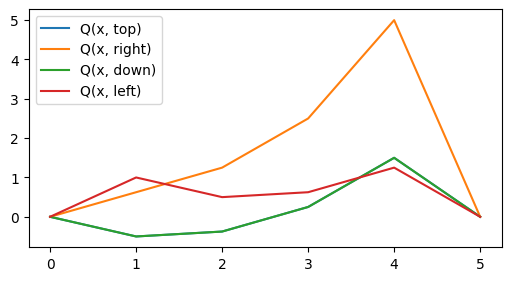

In [12]:
plot_qsa(Q)

In [13]:
# You can compute the optimal policy:
Q.max(1)

torch.return_types.max(
values=tensor([0.0000, 1.0000, 1.2500, 2.5000, 5.0000, 0.0000]),
indices=tensor([0, 3, 1, 1, 1, 0]))

If your implementation is working properly, you can now evaluate it on a larger MDP.

In [14]:
GRIDNAV = """
G: 1.0
x: -0.1
.: 0.0
---
xxxxxxx
x   xGx
x  x  x
x x   x
x     x
xs  xxx
xxxxxxx
"""

In [15]:
mdp = MDP(GRIDNAV)
mdp

xxxxxxx
x   xGx
x  x  x
x x   x
x     x
xs  xxx
xxxxxxx
Actions: 0: up, 1: right, 2: down, 3: left

In [16]:
Q = q_iteration(mdp, 0.95)

Finished in 11 iterations.


(<Figure size 640x480 with 2 Axes>, <Axes: >)

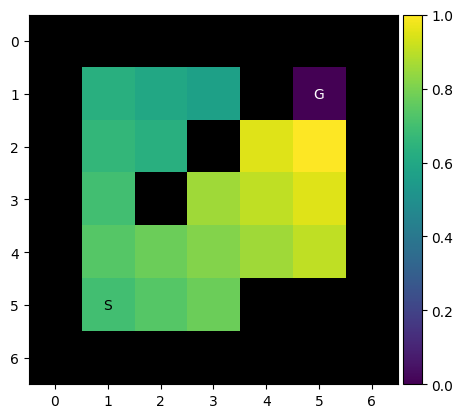

In [17]:
mdp.display(values=Q.max(1).values, cmap="viridis")